## Task-1
Исходные данные: временной ряд исторических котировок газа с поставкой на хаб ТТФ «на следующий день» за 01.01.2016-01.10.2018 (файлTTF_2.xlsx).
Описание финансового инструмента: 
Период действия: 01.10.2018-31.03.2019
Продавец финансового инструмента обязуется ежедневно по требованию Покупателя поставлять 1 млн куб. м газа. Цена на поставляемый газ определяется Покупателем за день до поставки как минимум из котировки «на следующий день» + 2 евро и фиксированной цены, равной 260 евро/тыс. куб. м. При этом Покупатель имеет право продавать получаемый от Продавца 1 млн куб. м на хабе с поставкой «на следующий день» по соответствующей цене.
Задание: оценить стоимость инструмента

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from scipy.stats import variation
from sklearn.metrics import r2_score, mean_squared_error, auc
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
!chcp 65001
!dir

Active code page: 65001
 Volume in drive C is Windows
 Volume Serial Number is E26C-6D7C

 Directory of C:\Users\Nikita\Documents\Р“Р°Р·РїСЂРѕРј (С‚РµСЃС‚РѕРІРѕРµ Р·Р°РґР°РЅРёРµ)\РўРµСЃС‚РѕРІРѕРµ Р·Р°РґР°РЅРёРµ

05.01.2021  15:16    <DIR>          .
05.01.2021  15:16    <DIR>          ..
04.01.2021  21:13    <DIR>          .ipynb_checkpoints
04.01.2021  21:02    <DIR>          Archive
28.04.2020  12:52            18В 292 data_for_regression.csv
28.12.2020  11:34           541В 735 Task-1_v1.ipynb
05.01.2021  15:16            72В 682 Task-2_v2.ipynb
04.01.2021  16:58           218В 009 Task-3_v2.ipynb
12.10.2018  21:27            21В 596 TTF_2.xlsx
04.06.2020  14:20            14В 415 РўРµСЃС‚РѕРІРѕРµ Р·Р°РґР°РЅРёРµ.docx
29.12.2020  11:39         1В 407В 378 РўРµСЃС‚РѕРІРѕРµ_Р·Р°РґР°РЅРёРµ.pdf
28.12.2020  20:21         1В 365В 433 РўРµСЃС‚РѕРІРѕРµ_Р·Р°РґР°РЅРёРµ.pptx
               8 File(s)      3В 659В 540 bytes
               4 Dir(s)  544В 150В 315В 008 bytes free


In [3]:
TTF2_data = '.\TTF_2.xlsx'

In [4]:
df = pd.read_excel(TTF2_data, usecols='C:D', header=2)

In [5]:
df.head()

,Unnamed: 2,"Котировка ТТФ день вперед, евро/тыс. куб. м"
0,2016-01-01,165.568
1,2016-01-04,162.760
2,2016-01-05,161.200
3,2016-01-06,162.240
4,2016-01-07,162.552


In [6]:
df = df.rename(columns={df.columns[0]: 'date', df.columns[1]: 'TTF'})
df.head()

,date,TTF
0,2016-01-01,165.568
1,2016-01-04,162.760
2,2016-01-05,161.200
3,2016-01-06,162.240
4,2016-01-07,162.552


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    714 non-null    datetime64[ns]
 1   TTF     714 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.3 KB


In [8]:
df.describe(include='all')

,date,TTF
count,714,714.000000
unique,714,NaN
top,2016-09-08 00:00:00,NaN
freq,1,NaN
first,2016-01-01 00:00:00,NaN
last,2018-10-01 00:00:00,NaN
mean,NaN,178.169916
std,NaN,25.626547
min,NaN,0.000000
25%,NaN,165.360000


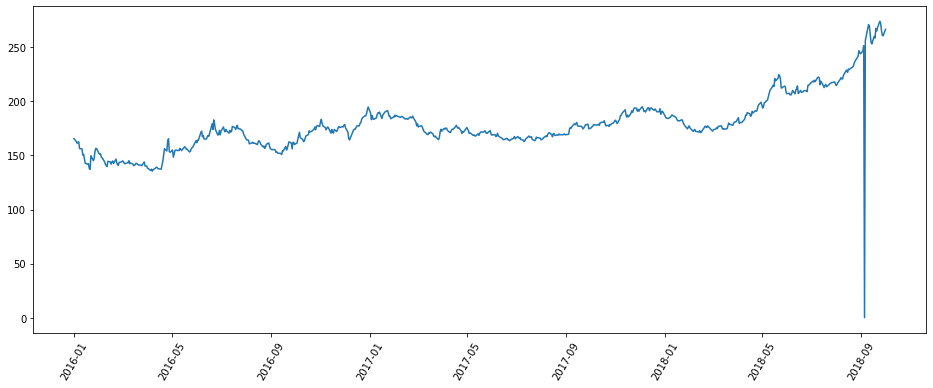

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['TTF'])
plt.xticks(rotation=60)
plt.show()

##### Fill the missed value

In [10]:
ttf_null = df.loc[df['TTF']==0, :].index[0]
df.loc[(ttf_null - 1):(ttf_null + 1), :]

,date,TTF
694,2018-09-04,251.368
695,2018-09-05,0.000
696,2018-09-06,256.360


In [11]:
df.loc[df['TTF']==0, ['TTF']] = np.around(np.average([df.loc[(ttf_null - 1), ['TTF']], df.loc[(ttf_null + 1), ['TTF']]]), 3)

In [12]:
df.describe(include='all')

,date,TTF
count,714,714.000000
unique,714,NaN
top,2016-09-08 00:00:00,NaN
freq,1,NaN
first,2016-01-01 00:00:00,NaN
last,2018-10-01 00:00:00,NaN
mean,NaN,178.525468
std,NaN,24.901943
min,NaN,135.512000
25%,NaN,165.360000


In [13]:
trow = df.set_index('date')

<AxesSubplot:xlabel='date'>

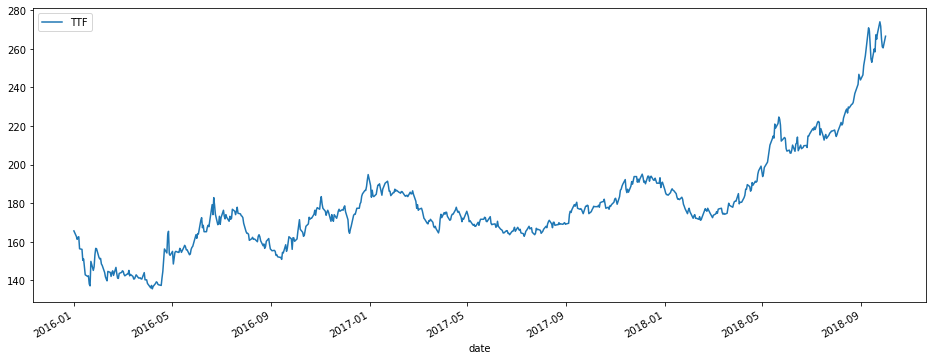

In [14]:
trow.plot(figsize=(16, 6))

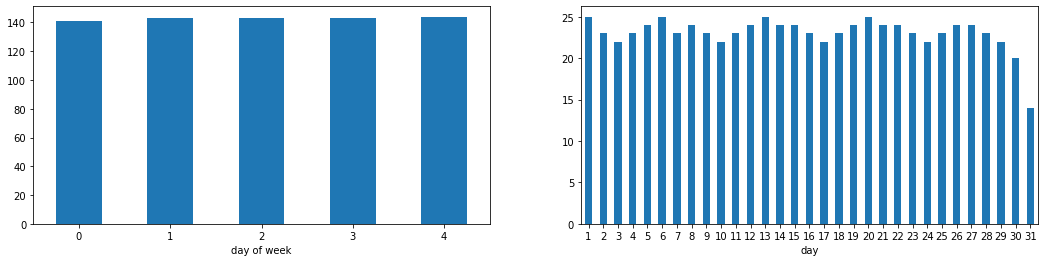

In [15]:
plt.subplot(121)
df['date'].groupby(df["date"].dt.dayofweek).count().plot(kind="bar", figsize=(18, 4), rot=0)
plt.xlabel('day of week')
plt.subplot(122)
df['date'].groupby(df["date"].dt.day).count().plot(kind="bar", rot=0)
plt.xlabel('day')
plt.show()

##### Create time series model

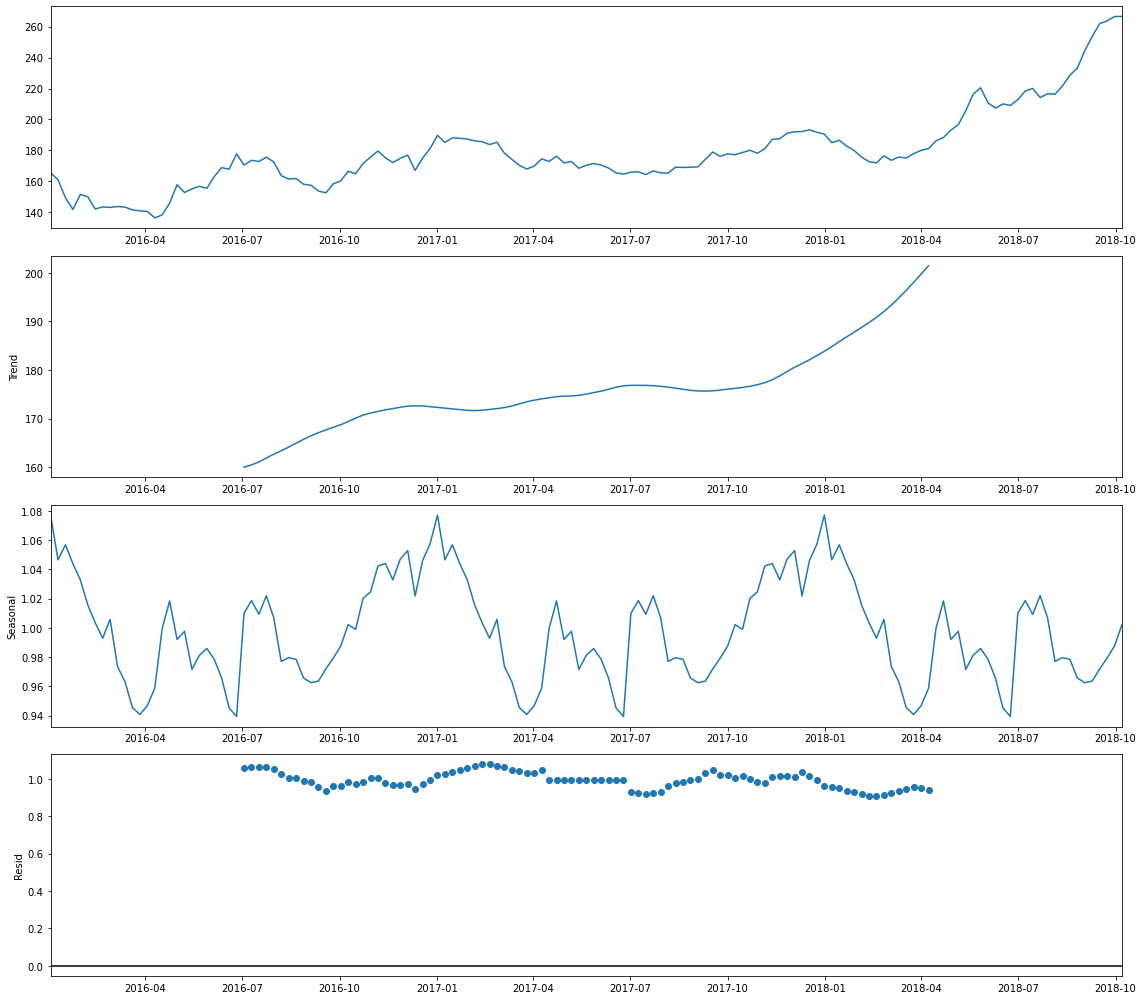

In [16]:
# Regularise time series to regular weeks (time series has missed values in dayoffs)
trow_week = trow.resample('W').mean()
result = seasonal_decompose(trow_week, model='multiplicative')
plt.rcParams.update({'figure.figsize': (16,14)})
result.plot()
plt.show()

In [17]:
trow_week

,TTF
date,
2016-01-03,165.5680
2016-01-10,161.0128
2016-01-17,149.4480
2016-01-24,141.8144
2016-01-31,151.6112
...,...
2018-09-09,253.6144
2018-09-16,261.9344
2018-09-23,263.7440


In [18]:
variation(trow, axis=0), variation(trow_week, axis=0)

(array([0.13938907]), array([0.14312101]))

In [19]:
trow_week_diff = trow_week.diff(periods=1).dropna()
sm.tsa.adfuller(trow_week_diff, maxlag=52)[1]

9.288626206490424e-11

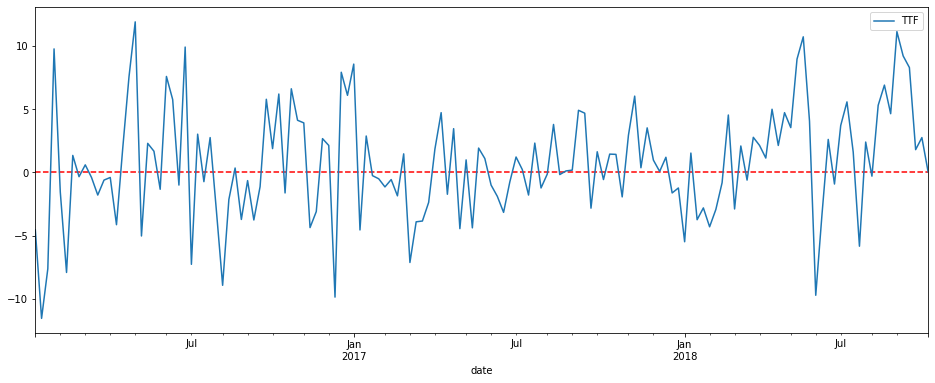

In [20]:
trow_week_diff.plot(figsize=(16,6))
plt.hlines(0, trow_week_diff.index[0], trow_week_diff.index[-1], color='red', linestyle='dashed')
plt.show()

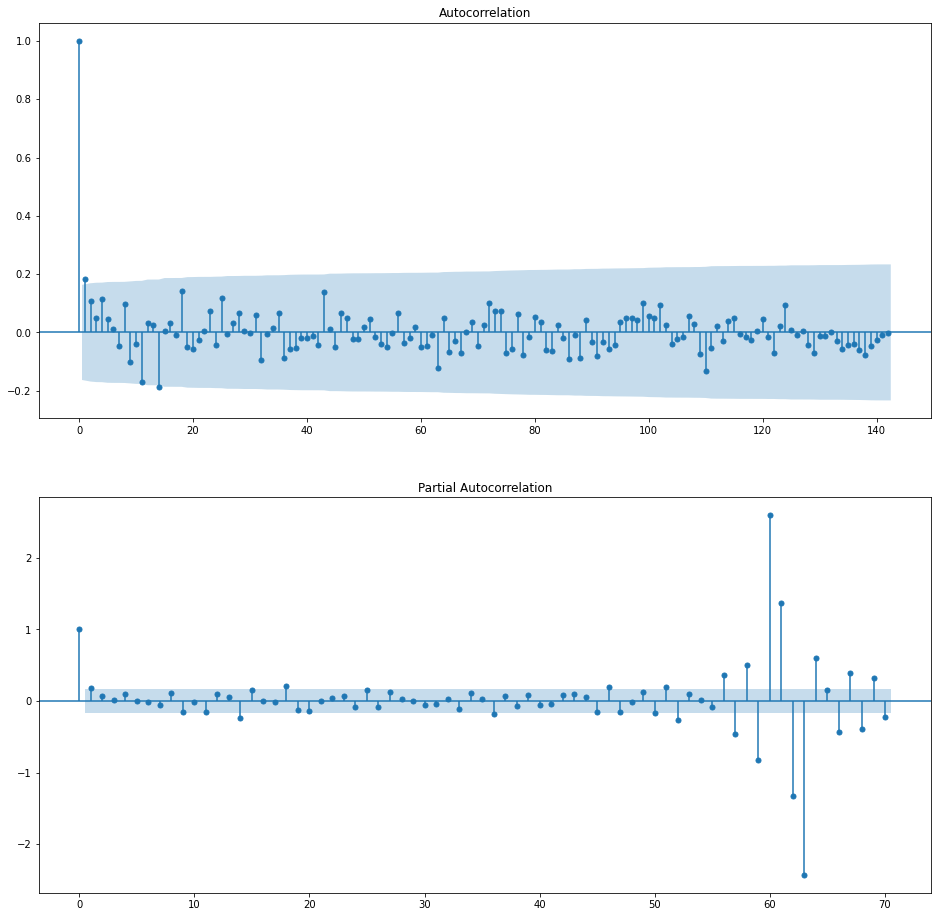

In [21]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trow_week_diff.values.squeeze(), lags=142, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trow_week_diff, lags=70, ax=ax2)

In [54]:
%%time
d, D = 1, 1
prediction = []
for p in range(4):
    for q in range(4):
        for P in range(4):
            for Q in range(4):
                print(f'p={p}, q={q}, P={P}, Q={Q} ', end='')
                model_sarima = sm.tsa.statespace.SARIMAX(trow_week, order=(p, d, q), seasonal_order=(P, D, Q, M)).fit()
                pred_sarima = model_sarima.predict('2016-01-10','2019-04-07', typ='levels')
                pred_sarima.index = pred_sarima.index - timedelta(days=7) # time shift
                prediction.append(pred_sarima)
                print('- done!')

p=0, q=0, P=0, Q=0 - done!
p=0, q=0, P=0, Q=1 - done!
p=0, q=0, P=0, Q=2 - done!
p=0, q=0, P=0, Q=3 - done!
p=0, q=0, P=1, Q=0 - done!
p=0, q=0, P=1, Q=1 - done!
p=0, q=0, P=1, Q=2 - done!
p=0, q=0, P=1, Q=3 - done!
p=0, q=0, P=2, Q=0 - done!
p=0, q=0, P=2, Q=1 - done!
p=0, q=0, P=2, Q=2 - done!
p=0, q=0, P=2, Q=3 - done!
p=0, q=0, P=3, Q=0 - done!
p=0, q=0, P=3, Q=1 - done!
p=0, q=0, P=3, Q=2 - done!
p=0, q=0, P=3, Q=3 - done!
p=0, q=1, P=0, Q=0 - done!
p=0, q=1, P=0, Q=1 - done!
p=0, q=1, P=0, Q=2 - done!
p=0, q=1, P=0, Q=3 - done!
p=0, q=1, P=1, Q=0 - done!
p=0, q=1, P=1, Q=1 - done!
p=0, q=1, P=1, Q=2 - done!
p=0, q=1, P=1, Q=3 - done!
p=0, q=1, P=2, Q=0 - done!
p=0, q=1, P=2, Q=1 - done!
p=0, q=1, P=2, Q=2 - done!
p=0, q=1, P=2, Q=3 - done!
p=0, q=1, P=3, Q=0 - done!
p=0, q=1, P=3, Q=1 - done!
p=0, q=1, P=3, Q=2 - done!
p=0, q=1, P=3, Q=3 - done!
p=0, q=2, P=0, Q=0 - done!
p=0, q=2, P=0, Q=1 - done!
p=0, q=2, P=0, Q=2 - done!
p=0, q=2, P=0, Q=3 - done!
p=0, q=2, P=1, Q=0 - done!
p

In [56]:
prediction = np.array(prediction)

In [57]:
prediction.shape

(256, 170)

In [69]:
df = pd.DataFrame(prediction).T
# df.to_csv('Prediction.csv')
# df.read_csv('Prediction.csv', sep=',')
df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,165.5680,165.568000,165.568000,165.568000,165.568000,165.568000,165.568000,165.568000,165.568000,165.568000,...,165.568467,165.568463,165.568527,165.568481,165.568451,165.568481,165.568471,165.568479,165.568496,165.568470
1,161.0128,161.012800,161.012800,161.012800,161.012800,161.012800,161.012800,161.012800,161.012800,161.012800,...,161.012809,161.012872,161.012892,161.012855,161.012830,161.012826,161.012850,161.012841,161.012857,161.012818
2,149.4480,149.448000,149.448000,149.448000,149.448000,149.448000,149.448000,149.448000,149.448000,149.448000,...,149.447781,149.447803,149.447795,149.447789,149.447746,149.447753,149.447765,149.447783,149.447774,149.447749
3,141.8144,141.814400,141.814400,141.814400,141.814400,141.814400,141.814400,141.814400,141.814400,141.814400,...,141.814624,141.814584,141.814611,141.814601,141.814567,141.814598,141.814581,141.814609,141.814601,141.814593
4,151.6112,151.611200,151.611200,151.611200,151.611200,151.611200,151.611200,151.611200,151.611200,151.611200,...,151.611578,151.611578,151.611629,151.611594,151.611578,151.611599,151.611594,151.611593,151.611611,151.611590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,265.0544,266.489424,266.416081,266.359904,266.722444,266.608418,266.607418,266.594354,266.722084,266.630759,...,283.840113,283.314224,284.511183,284.126216,281.962427,283.589966,284.147458,284.052121,284.362941,283.020482
166,264.4512,265.346491,265.288941,265.244884,265.529187,265.439772,265.438923,265.428751,265.528871,265.457292,...,282.130289,281.530650,282.412219,282.176406,280.019128,281.650491,282.384378,282.050063,282.325975,281.119526
167,267.2384,267.224180,267.175467,267.138248,267.378349,267.302849,267.301921,267.293568,267.377968,267.317646,...,284.138567,283.427937,283.987730,283.932119,281.757384,283.406035,284.304044,283.742173,283.968375,282.938813
168,269.3808,269.235025,269.161456,269.105257,269.467795,269.353797,269.352366,269.339787,269.467202,269.376140,...,287.840212,287.059240,288.080592,287.930131,285.675968,287.417692,288.204227,287.779418,288.088437,286.886705


In [157]:
mean_sequence = df.mean(axis=1)
max_sequence = df.loc[:, df.sum(axis=0)==df.sum(axis=0).max()]
min_sequence = df.loc[:, df.sum(axis=0)==df.sum(axis=0).min()]
time_index = pd.date_range('2016-01-03','2019-03-31', freq='W')
mean_sequence = pd.DataFrame(data=mean_sequence.values, index=time_index)
max_sequence = pd.DataFrame(data=max_sequence.values, index=time_index)
min_sequence = pd.DataFrame(data=min_sequence.values, index=time_index)

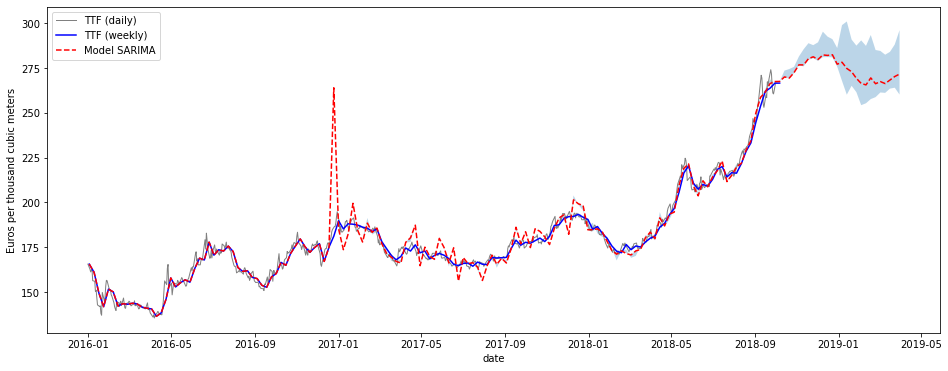

In [158]:
plt.figure(figsize=(16,6))
plt.plot(trow, color='gray', linewidth=1, label='TTF (daily)')
plt.plot(trow_week, color='blue', linewidth=1.5, label='TTF (weekly)')
plt.plot(mean_sequence, color='red', linestyle='dashed', label='Model SARIMA')
plt.fill_between(time_index, min_sequence.values.flatten(), max_sequence.values.flatten(), alpha=0.3)
plt.legend()
plt.ylabel('Euros per thousand cubic meters')
plt.xlabel('date')
plt.show()

In [159]:
y = trow_week['TTF']
y_pred = mean_sequence.loc[mean_sequence.index <= '2018-10-07']
print(f'R2: {r2_score(y, y_pred)}, MSE: {mean_squared_error(y, y_pred)}, RMSE: {np.sqrt(mean_squared_error(y, y_pred))}')

R2: 0.909119568971819, MSE: 59.72106526489756, RMSE: 7.727940557800478


##### Estimate the cost of tool

In [27]:
def calc_tool_cost(start_date: datetime, end_date: datetime, time_series: pd.Series):
    """
    Method calculate total cost and daily average cost relying on period and weekly sarima prediction
    :start_date: datetime
    :end_date: datetime
    :time_series: pandas.Series
    """
    ttf = pd.DataFrame()
    ttf['date'] = pd.date_range(start_date, end_date, freq='D')
    ttf = ttf.set_index('date')
    ts_df = pd.DataFrame({'date': time_series.index, 'TTF': time_series.values})
    ts_df = ts_df.set_index('date')
    ttf = pd.merge(ttf, ts_df, how='left', on='date')
    ttf['TTF'] = ttf['TTF'].bfill()
    ttf = ttf[ttf.index.dayofweek < 5]
    ttf['TTF_cost'] = ttf['TTF'] + 2  # TTF + 2 euros
    ttf['fixed_cost'] = 260  # fixed 260 euros
    ttf['cost'] = ttf[['TTF_cost', 'fixed_cost']].min(axis=1)  # minimum between (TTF + 2) and 260 euros
    ttf.drop(columns=['TTF_cost', 'fixed_cost'], inplace=True)  # drop temporary columns
    ttf['profit'] = np.where((ttf['TTF'] - ttf['cost'])>0, ttf['TTF'] - ttf['cost'], 0)  # profit of gas selling at the TTF price
    total_cost = np.around((ttf['profit'].sum() * 1000), 2) # contract for 1 Mcm per day
    average_cost = np.around((ttf['profit'].mean() * 1000),2) # contract for 1 Mcm per day
    print(f'Calc period:        from {start_date} to {end_date}\n'
          f'Days in period: {ttf.shape[0]:>7} days\n'
          f'Cost of tool: {total_cost:>16} euros per period\n'
          f'Avg profit per day: {average_cost} euros per day')

In [160]:
# Mean
calc_tool_cost('2018-10-01', '2019-03-31', mean_sequence[0])

Calc period:        from 2018-10-01 to 2019-03-31
Days in period:     130 days
Cost of tool:       1719544.88 euros per period
Avg profit per day: 13227.27 euros per day


In [161]:
calc_tool_cost('2018-10-01', '2019-03-31', min_sequence[0])

Calc period:        from 2018-10-01 to 2019-03-31
Days in period:     130 days
Cost of tool:       1165464.95 euros per period
Avg profit per day: 8965.12 euros per day


In [162]:
calc_tool_cost('2018-10-01', '2019-03-31', max_sequence[0])

Calc period:        from 2018-10-01 to 2019-03-31
Days in period:     130 days
Cost of tool:       3489692.38 euros per period
Avg profit per day: 26843.79 euros per day
